# Deconvolution for layer visualisation

Investigate deconvnets. Initially, we are copying an example that uses a VGG rather than a resnet. It is not currently clear what problems are associated with resnets, or if they can even be used for this.

This notebook reproduces the results of https://github.com/jalused/Deconvnet-keras/blob/master/Deconvnet-keras.py after converting to use TF2.2

## Try looking at block5_conv3 - last convolution layer

In [56]:
%cd /home/jupyter/dev/tflow/deconvnet/Deconvnet-keras
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/jupyter/dev/tflow/deconvnet/Deconvnet-keras


In [57]:
import os
import sys
from pathlib import Path
from os import path

from Deconvnet import *
import matplotlib.pyplot as plt
import librosa


In [58]:
model = tf.keras.models.load_model("/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-49")

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 431, 128, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 431, 128, 3)       6         
_________________________________________________________________
vgg16 (Model)                (None, 13, 4, 512)        14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                12825     
Total params: 14,727,519
Trainable params: 14,727,519
Non-trainable params: 0
_______________________________________________

In [208]:
model.layers[2].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 431, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 431, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 431, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 215, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 215, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 215, 64, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 107, 32, 128)      0     

In [209]:
LAYER_NAME = 'block5_conv3'
deconv_layers = create_deconv(model, LAYER_NAME)

input_3
conv2d_1
vgg16
input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3


In [210]:
deconv_layers

In [211]:
def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)   
    #S = librosa.feature.melspectrogram(y=y, sr=sr)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        fmax=(sr / 2.0),
        fmin=0.0,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )
    S = librosa.power_to_db(S)
    S = np.transpose(S)
    return S[np.newaxis, 0:431, :, np.newaxis]

In [64]:
recordings_dir = "/home/jupyter/dev/tflow/unit_test_files"

In [203]:
def show_image(spectro, cmap='gray'):
    _,ax = plt.subplots(figsize=(10,10))

    spectro = np.rot90(spectro)
    ax.axis('off')
    #ax.set_title(f"{layers[i]}:")
    ax.imshow(spectro, cmap=cmap)
    #ax.imshow(spectro)

In [212]:
def forward_pass(deconv_layers, data):
    # Forward pass
    deconv_layers[0].up(data)
    for i in range(1, len(deconv_layers)):
        #print(f"{i}")
        deconv_layers[i].up(deconv_layers[i - 1].up_data)

    return deconv_layers[-1].up_data

In [213]:
output = forward_pass(deconv_layers, extract_feature(path.join(recordings_dir,"vacuum_cleaner.wav")))

In [214]:
def backward_pass(deconv_layers, output, feature_to_visualize, visualize_mode):
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:, :, :, feature_to_visualize]
    if 'max' == visualize_mode:
        feature_map = feature_map.numpy()
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
    elif 'all' != visualize_mode:
        print('Illegal visualize mode')
        sys.exit()
    output = np.zeros_like(output)
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:, :, :, feature_to_visualize] = feature_map

    # Backward pass
    deconv_layers[-1].down(output)
    for i in range(len(deconv_layers) - 2, -1, -1):
        #print(f"d: {i}")
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()
    
    return deconv

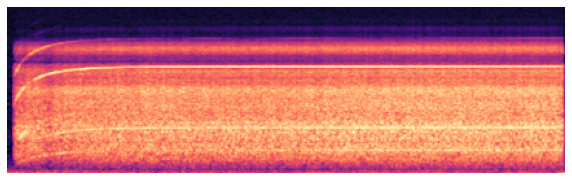

In [207]:
s = extract_feature(path.join(recordings_dir,"vacuum_cleaner.wav"))
show_image(s[0,:,:,0],'magma')

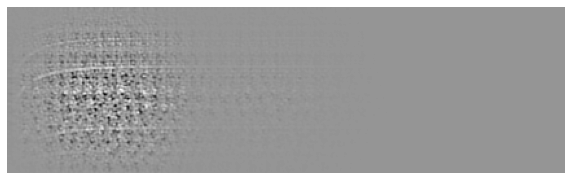

In [215]:
result = backward_pass(deconv_layers, output, 46, 'all')
show_image(result)

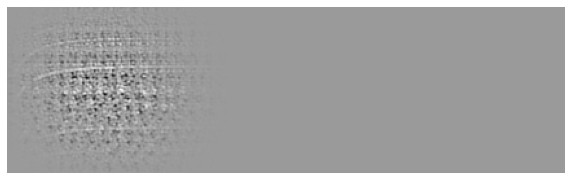

In [216]:
result = backward_pass(deconv_layers, output, 46, 'max')
show_image(result)

In [217]:
def max_activation(output):
    a = np.mean(np.mean(output[0,:,:,:],axis=0), axis=0)
    return (-a).argsort()

def multiplot(layers, mode='all', rows=4, cols=2):
    _,axes = plt.subplots(rows,cols,figsize=(15,10))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(layers):
            break
        r = backward_pass(deconv_layers, output, layers[i], mode)
        spectro = np.rot90(r)
        #spectro = spectro[::-1,:]
        ax.axis('off')
        ax.set_title(f"{layers[i]}:")
        ax.imshow(spectro, cmap='gray')




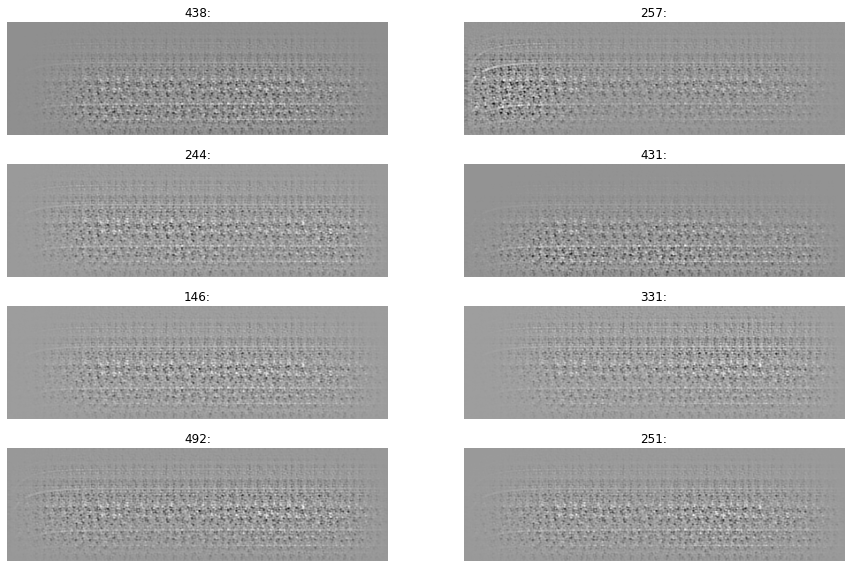

In [218]:
max_act = max_activation(output)
multiplot(max_act[:8])

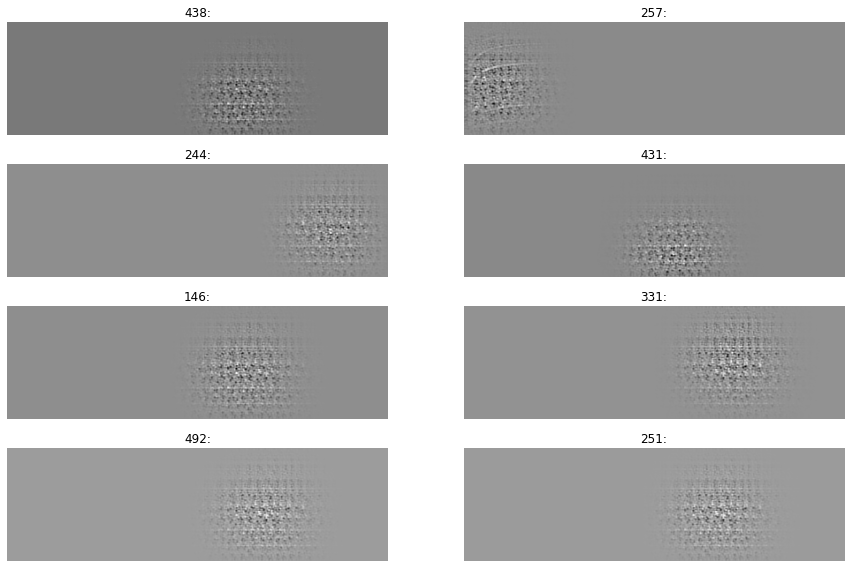

In [219]:
multiplot(max_act[:8],'max')

In [225]:
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    import tensorflow.lite as tflite

def get_human_readable_output(output):
    results = [
        'breathing', 'car_horn', 'cat',
        'chainsaw', 'chirping_birds',
        'clapping', 'coughing', 'cow',
        'crickets', 'dog', 'door_wood_knock',
        'engine', 'frog', 'glass_breaking',
        'hen', 'laughing', 'rain', 'rooster',
        'sheep', 'siren', 'sneezing',
        'snoring', 'thunderstorm',
        'vacuum_cleaner', 'wind'
    ]

    output = list(output[0])

    largest = max(output)
    index = list(output).index(largest)
    #return results[index]
    result = f"{largest * 100:.2f}% confident that this is a {results[index]}"

    formatted_output = [f"{o*100:05.2f}" for o in output]
    stats = [f"{x}%: {results[i]}" for i, x in enumerate(formatted_output)]

    return result, "\n".join(stats)


def infer_from_file(filename, model_path="/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-52.tflite"):
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_data = extract_feature(filename)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    predicted_data_vector = interpreter.get_tensor(output_details[0]['index'])

    return get_human_readable_output(predicted_data_vector)

In [226]:
infer_from_file(path.join(recordings_dir,"coughing.wav"))

('97.72% confident that this is a coughing',
 '00.15%: breathing\n00.04%: car_horn\n00.01%: cat\n00.01%: chainsaw\n00.00%: chirping_birds\n00.01%: clapping\n97.72%: coughing\n00.01%: cow\n00.12%: crickets\n00.08%: dog\n00.26%: door_wood_knock\n00.00%: engine\n00.03%: frog\n00.02%: glass_breaking\n00.42%: hen\n00.42%: laughing\n00.02%: rain\n00.04%: rooster\n00.01%: sheep\n00.01%: siren\n00.53%: sneezing\n00.03%: snoring\n00.00%: thunderstorm\n00.06%: vacuum_cleaner\n00.02%: wind')

In [227]:
infer_from_file(path.join(recordings_dir,"dog.wav"))

('97.80% confident that this is a sneezing',
 '00.02%: breathing\n00.01%: car_horn\n00.00%: cat\n00.00%: chainsaw\n00.00%: chirping_birds\n00.00%: clapping\n00.23%: coughing\n00.00%: cow\n00.00%: crickets\n01.82%: dog\n00.02%: door_wood_knock\n00.00%: engine\n00.03%: frog\n00.00%: glass_breaking\n00.00%: hen\n00.00%: laughing\n00.00%: rain\n00.02%: rooster\n00.02%: sheep\n00.00%: siren\n97.80%: sneezing\n00.00%: snoring\n00.01%: thunderstorm\n00.01%: vacuum_cleaner\n00.00%: wind')